# ContriMix demo notebook from TCGA pre-trained model
This notebook demonstrates how to use the pre-trained model from TCGA with Contrimix.

In [66]:
%reload_ext autoreload
%autoreload 2

In [92]:
%matplotlib inline

In [67]:
model_path = "./checkpoints/tcga_unlabeled_seed:0_epoch:19_model.pth"

In [75]:
import torch
from ip_drit.models import AbsorbanceImGenerator
from ip_drit.models import AbsorbanceToTransmittance
from ip_drit.models import TransmittanceToAbsorbance
from ip_drit.models import AttributeEncoder
from ip_drit.models import ContentEncoder

In [76]:
from saving_utils import load_model_state_dict_from_checkpoint

In [81]:
num_attr_vectors = 16
down_sampling_factor = 1

In [84]:
# Encoder parameters
content_encoder = ContentEncoder(
    in_channels=3, 
    num_stain_vectors=num_attr_vectors,
    k=down_sampling_factor)

attribute_encoder = AttributeEncoder(
    in_channels=3,
    num_stain_vectors=num_attr_vectors,
    k=down_sampling_factor)

im_generator = AbsorbanceImGenerator(
    k=down_sampling_factor
)
    
trans_to_abs = TransmittanceToAbsorbance()
abs_to_trans = AbsorbanceToTransmittance()

In [85]:
# Just get the encoders from the model.
content_encoder.load_state_dict(
    load_model_state_dict_from_checkpoint(model_path, start_str="_models_by_names.cont_enc.module.")
)

attribute_encoder.load_state_dict(
    load_model_state_dict_from_checkpoint(model_path, start_str="_models_by_names.attr_enc.module.")
)

im_generator.load_state_dict(
    load_model_state_dict_from_checkpoint(model_path, start_str="_models_by_names.im_gen.module.")
)

<All keys matched successfully>

Modify the path below to try different images.

In [225]:
im1_path = './sample_data/462.png'
im2_path = './sample_data/172.png'

In [226]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

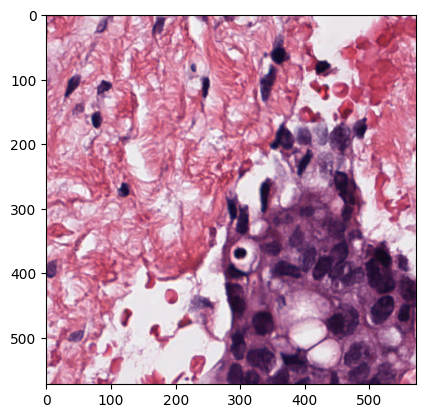

In [227]:
im1 = np.array(Image.fromarray(cv2.imread(im1_path))) / 255.0
plt.figure()
plt.imshow(im1)
plt.show()

In [228]:
im1_tensor = torch.permute(torch.tensor(im1), (2,0,1))
im1_tensor = im1_tensor.unsqueeze(0).type(torch.float32)

In [229]:
im_abs1 = trans_to_abs(im1_tensor)
zc1 = content_encoder(im_abs1) 
za1 = attribute_encoder(im_abs1)

# Part 1: Evalutate the self-reconstruction for quality

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


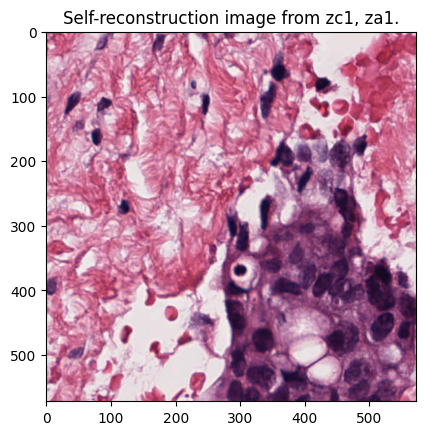

In [230]:
im_abs1_recon = im_generator(zc1, za1)
im1_recon = abs_to_trans(im_abs1_recon)
im1_recon = im1_recon[0].permute(1,2,0).detach().numpy()

plt.figure()
plt.imshow(im1_recon)
plt.title('Self-reconstruction image from zc1, za1.')
plt.show()

# Part 2: Look at some cross-reconstruction

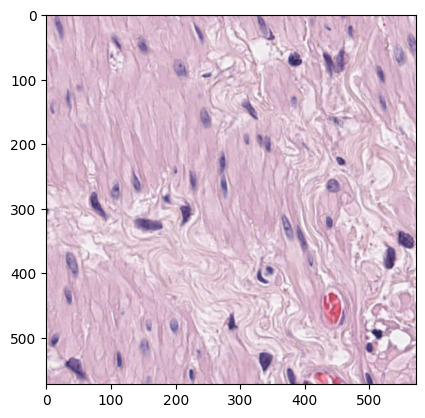

In [231]:
im2 = np.array(Image.fromarray(cv2.imread(im2_path))) / 255.0
plt.figure()
plt.imshow(im2)
plt.show()

In [232]:
im2_tensor = torch.permute(torch.tensor(im2), (2,0,1))
im2_tensor = im2_tensor.unsqueeze(0).type(torch.float32)
im_abs2 = trans_to_abs(im2_tensor)
zc2 = content_encoder(im_abs2) 
za2 = attribute_encoder(im_abs2)

Now, look at some cross-interaction between attribute and content.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


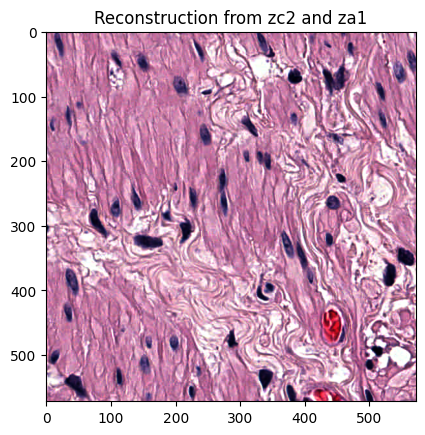

In [233]:
im_abs2_zc2_za1 = im_generator(zc2, za1)
im_abs2_zc2_za1 = abs_to_trans(im_abs2_zc2_za1)
im_abs2_zc2_za1 = im_abs2_zc2_za1[0].permute(1,2,0).detach().numpy()

plt.figure()
plt.imshow(im_abs2_zc2_za1)
plt.title('Reconstruction from zc2 and za1')
plt.show()

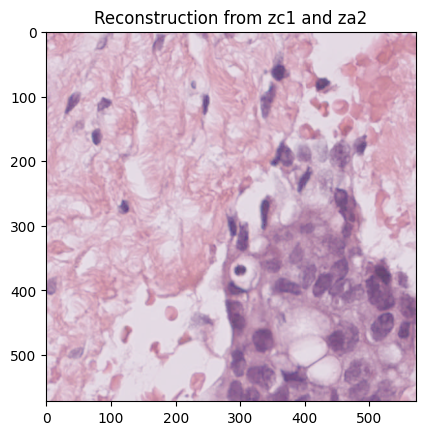

In [234]:
im_abs2_zc1_za2 = im_generator(zc1, za2)
im_abs2_zc1_za2 = abs_to_trans(im_abs2_zc1_za2)
im_abs2_zc1_za2 = im_abs2_zc1_za2[0].permute(1,2,0).detach().numpy()

plt.figure()
plt.imshow(im_abs2_zc1_za2)
plt.title('Reconstruction from zc1 and za2')
plt.show()